In [38]:
from pymonntorch import NeuronGroup, SynapseGroup, NeuronDimension, Recorder, Behavior, EventRecorder
import random
from conex import (
    Neocortex,
    InputLayer,
    Synapsis,
    prioritize_behaviors,
)
from conex.behaviors.neurons import (
    SimpleDendriteStructure,
    SimpleDendriteComputation,
    LIF,
    SpikeTrace,
    NeuronAxon,
    Fire,
    KWTA,
    ActivityBaseHomeostasis
)
from conex.behaviors.synapses import (
    SynapseInit,
    WeightInitializer,
    SimpleDendriticInput,
    Conv2dDendriticInput,
    LateralDendriticInput,
    AveragePool2D,
    SimpleSTDP,
    Conv2dSTDP,
    WeightClip,
    WeightNormalization
)
from conex.helpers.filters import (
    DoGFilter,
    GaborFilter
)
from conex.helpers.transforms.encoders import(
    Intensity2Latency,
    SimplePoisson
)
from conex.helpers.transforms.misc import(
    Conv2dFilter,
    SqueezeTransform
)
import torch
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import poisson
import plotly.graph_objects as go
import plotly.express as px

import os
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.datasets as datasets
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import torch
import numpy as np


In [39]:
class FaceDataset(Dataset):
    def __init__(self, root_dir, transform = None) -> None:
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = os.listdir(root_dir)
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image

In [40]:
##################################################
# parameters
##################################################
DEVICE = "cpu"
DTYPE = torch.float32
DT = 1

TAU_S = 10


# KWTA
K = 1
DIM = 0

# LAT. INH.
LAT_COEF = 100
D = 3
W = 10
H = 10

# ACT BASED HOMOSTASIS
WIN_S = 100
ACT_R = 20
UPD_R = 0.01
DEC_R = 1.0


# STDP
A_PLUS = 0.001
A_MINUS = 0.001

# DOG
DOG_SIZE = 15
DOG_SIGMA1 = 1
DOG_SIGMA2 = 0.5

# POISSON
POISSON_TIME = 50
POISSON_RATIO = 10

# DATA SET
CELEBA_HEIGHT = 100
CELEBA_WIDTH = 100

DL_HEIGHT = CELEBA_HEIGHT
DL_WIDTH = CELEBA_WIDTH

# INPUT LAYER
SENSORY_SIZE_HEIGHT = DL_HEIGHT-DOG_SIZE+1
SENSORY_SIZE_WIDTH = DL_WIDTH-DOG_SIZE+1

SENSORY_TRACE_TAU_S = 2.7
SENSORY_SILENCE = 10

# OUTPUT LAYER
LIF_OUTPUT1 = {"R":8 , "threshold":-37 , "tau":10 , "v_reset":-65 , "v_rest":-60, "init_v":-50}
LIF_OUTPUT2 = {"R":5 , "threshold":-65 , "tau":10 , "v_reset":-68 , "v_rest":-67, "init_v":-67}
LIF_OUTPUT = LIF_OUTPUT2

f=D
CONV_SIZE = 80

OUTPUT_SIZE_HEIGHT = SENSORY_SIZE_HEIGHT-CONV_SIZE+1
OUTPUT_SIZE_WIDTH = SENSORY_SIZE_WIDTH-CONV_SIZE+1

INP_OUT_WEIGHT_SHAPE = (f,1,CONV_SIZE,CONV_SIZE)
NORM = CONV_SIZE*CONV_SIZE/2


In [41]:
dog_filter = DoGFilter(size = DOG_SIZE, sigma_1 = DOG_SIGMA1, sigma_2 = DOG_SIGMA2, zero_mean=True, one_sum=True ,device="cpu", dtype=torch.float32)
conv = Conv2dFilter(dog_filter.unsqueeze(0).unsqueeze(0), stride=1, padding=0)
# encoder = Intensity2Latency(time_window=I2L_TIME, threshold=I2L_THRESHOLD,sparsity=I2L_SPARSITY)
encoder = SimplePoisson(time_window=POISSON_TIME, ratio=POISSON_RATIO)
transformation = transforms.Compose(
    [
        transforms.Resize((CELEBA_HEIGHT,CELEBA_WIDTH)),
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=1),
        conv,
        encoder,
        SqueezeTransform(1)
    ]
)


dataset = FaceDataset(root_dir = "./data/celeba", transform = transformation)
NUM_SAMPLES = 1
# indices = random.sample(range(len(dataset)), NUM_SAMPLES)
# 0,3,22,40
indices = [9,1,52,22,40,51,12,55,35]*10
data_subset = torch.utils.data.Subset(dataset, indices)
dataloader = DataLoader(dataset = data_subset, batch_size = NUM_SAMPLES, shuffle = True)


In [42]:
# NEOCORTEX & INPUT LAYER
net = Neocortex(dt=DT, device=DEVICE, dtype=DTYPE)

input_layer = InputLayer(
    net=net,
    input_dataloader=dataloader,
    have_sensory=True,
    have_location=False,
    have_label=False,
    sensory_size=NeuronDimension(
        depth=1, height=SENSORY_SIZE_HEIGHT, width=SENSORY_SIZE_WIDTH
    ),
    sensory_trace=SENSORY_TRACE_TAU_S,
    instance_duration=POISSON_TIME,
    silent_interval=SENSORY_SILENCE,
    sensory_data_dim=2
)



In [43]:
# OUTPUT LAYER
behavior_out = {
        5: SimpleDendriteStructure(),
        6: SimpleDendriteComputation(),
        10: LIF(
                R=LIF_OUTPUT["R"],
                threshold=LIF_OUTPUT["threshold"],
                tau=LIF_OUTPUT["tau"],
                v_reset=LIF_OUTPUT["v_reset"],
                v_rest=LIF_OUTPUT["v_rest"],
                init_v=LIF_OUTPUT["init_v"]
            ),
        15: KWTA(k=K,dimension=DIM),
        20: Fire(),
        # 25: ActivityBaseHomeostasis(window_size=WIN_S, activity_rate=ACT_R, updating_rate=UPD_R, decay_rate=DEC_R),
        30: SpikeTrace(tau_s=TAU_S),
        40: NeuronAxon(),
        90: Recorder(tag="pop2_rec", variables=["v", "I"]),
        100: EventRecorder(tag="pop2_evrec", variables=["spikes"])
}

output_layer = NeuronGroup(net=net, 
                           size=NeuronDimension(depth=f, height=OUTPUT_SIZE_HEIGHT, width=OUTPUT_SIZE_WIDTH), 
                           behavior=behavior_out)

In [44]:
# SYNAPSES
behavior_syn={
    2: SynapseInit(),
    3: WeightInitializer(mode="normal(0.5,0.01)", weight_shape=INP_OUT_WEIGHT_SHAPE, kernel_shape=INP_OUT_WEIGHT_SHAPE),
    180: Conv2dDendriticInput(current_coef=10),
    400: Conv2dSTDP(a_plus=A_PLUS, a_minus=A_MINUS),
    420: WeightNormalization(norm=NORM),
    440: WeightClip(w_max=1,w_min=0),
    1000: Recorder(tag="syn_rec", variables=["weights"])
}

syn_inp_out = SynapseGroup(
    net=net,
    tag="Proximal",
    src=input_layer.sensory_pop,
    dst=output_layer,
    behavior=behavior_syn,
)

syn_lateral = SynapseGroup(
    net = net,
    src = output_layer,
    dst = output_layer,
    tag = "Proximal, inh", 
    behavior=prioritize_behaviors([
    SynapseInit(),
    WeightInitializer(mode=0.2, weight_shape=(1,1,1+2*D,1+2*H,1+2*W)),
    LateralDendriticInput(inhibitory=True, current_coef=LAT_COEF),
]))


it = 1000
net.initialize(info=False)
net.simulate_iterations(it)

100%|██████████| 1000/1000 [00:09<00:00, 102.19it/s]

1000xBatch: 1/1 (100%) 9789.406ms


9789.406299591064

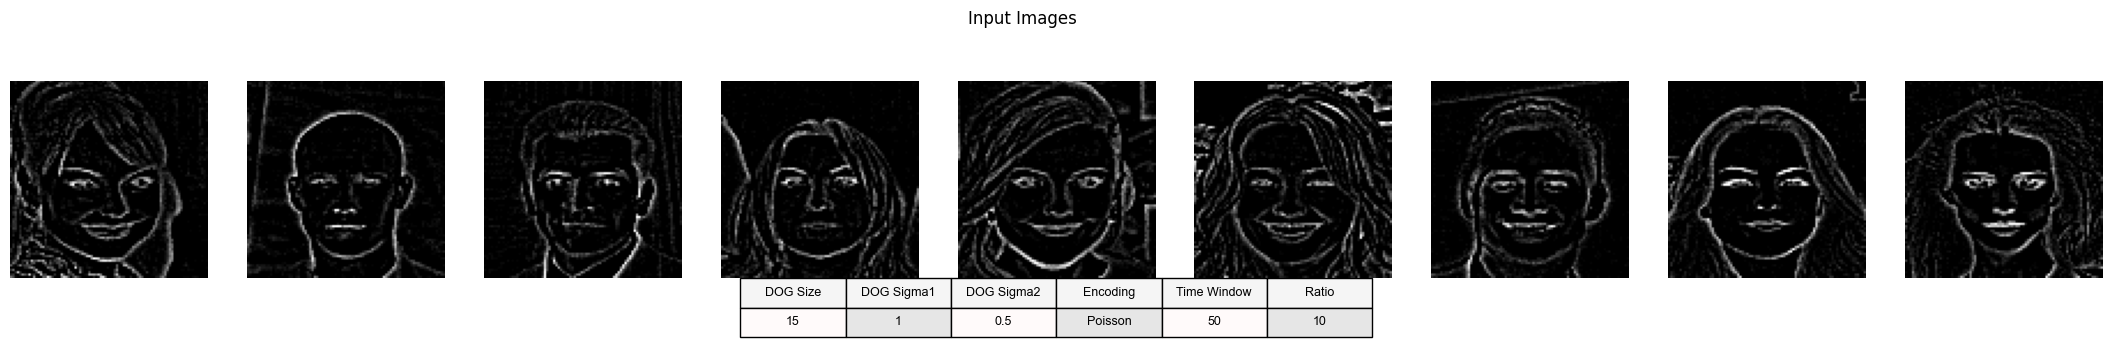

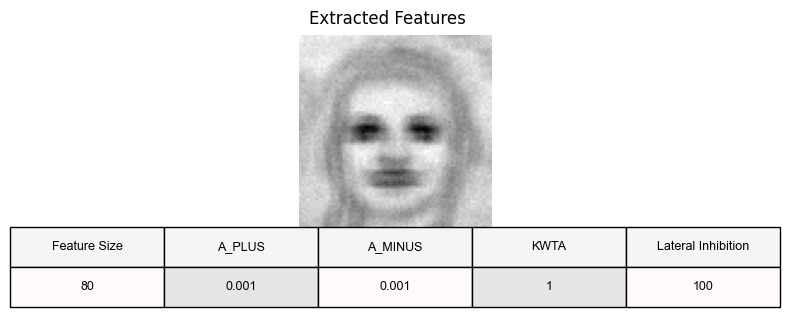

In [45]:
def display_images_and_params(input_images, output_images, paramsI, paramsO):
    num_plots = len(indices)//10
    fig, axes = plt.subplots(1, num_plots, figsize=(3*num_plots, 3.5))
    if num_plots == 1:
        axes = [axes]
    for i in range(num_plots):
        axes[i].axis('off')
        axes[i].imshow(input_images[i], cmap='gray')
    fig.suptitle("Input Images")
    FONT = "arial"
    parameters = list(paramsI.keys())
    values = list(paramsI.values())
    table_data = [parameters, values]
    table = axes[num_plots//2].table(cellText = table_data, cellLoc = "center", loc = "bottom")
    table.scale(0.8, 0.8)
    table.set_fontsize(9)
    for i in range(len(parameters)):
            table[(0, i)].set_facecolor("whitesmoke")
            table[(0, i)].set_text_props(color = 'black', fontfamily = FONT)

    for i in range(len(values)):
            table[(1, i)].set_facecolor("snow" if i % 2 == 0 else '#e6e6e6')
            table[(1, i)].set_text_props(fontfamily = FONT)
    table.auto_set_font_size(False)
    table.scale(4, 3)
    plt.show()


    l = len(output_images)
    fig, axes = plt.subplots(1, l, figsize=(2*f, 2.5))
    if l == 1:
        axes = [axes]
    for i in range(l):
        axes[i].axis('off')
        axes[i].imshow(output_images[i], cmap='gray')
    fig.suptitle("Extracted Features")
    
    FONT = "arial"
    parameters = list(paramsO.keys())
    values = list(paramsO.values())
    table_data = [parameters, values]
    table = axes[l//2].table(cellText = table_data, cellLoc = "center", loc = "bottom")
    table.scale(0.8, 0.8)
    table.set_fontsize(9)
    for i in range(len(parameters)):
            table[(0, i)].set_facecolor("whitesmoke")
            table[(0, i)].set_text_props(color = 'black', fontfamily = FONT)

    for i in range(len(values)):
            table[(1, i)].set_facecolor("snow" if i % 2 == 0 else '#e6e6e6')
            table[(1, i)].set_text_props(fontfamily = FONT)
    table.auto_set_font_size(False)
    table.scale(5, 3)
    plt.show()
    
input_images = [data_subset[i].cpu().sum(0) for i in range(len(indices)//10)]
output_images = [syn_inp_out.weights[i].squeeze(0) for i in range(f)]

paramsI = {"DOG Size": DOG_SIZE, 
           "DOG Sigma1": DOG_SIGMA1, "DOG Sigma2": DOG_SIGMA2, 
           "Encoding": "Poisson",
           "Time Window": POISSON_TIME, "Ratio": POISSON_RATIO}
paramsO = {"Feature Size": CONV_SIZE, "A_PLUS": A_PLUS, "A_MINUS": A_MINUS, 
           "KWTA": K, "Lateral Inhibition": LAT_COEF}

display_images_and_params(input_images, [output_images[0]], paramsI,paramsO)
